In [1]:
from keras import layers, models, optimizers
from keras import initializers , preprocessing, utils
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import gc
import seaborn as sns
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import normalize
import pprint as pp
from sklearn.preprocessing import normalize

Using TensorFlow backend.


## Model 1 (skills output)

In [2]:
class LOLModel:
    
    def __init__(self, model_info):
        self.input_shape = model_info['input_shape'] 
        self.units_first = model_info['units_first'] if 'units_first' in model_info else None
        self.activation_first = model_info['activation_first']
        self.units_hidden = model_info['units_hidden'] if 'units_hidden' in model_info else None
        self.activations_hidden = model_info['activations_hidden']
        self.units_last = model_info['units_last'] if 'units_last' in model_info else None
        self.activation_last = model_info['activation_last']
        self.filters_first = model_info['filters_first'] if 'filters_first' in model_info else None
        self.filters = model_info['filters'] if 'filters' in model_info else None
        self.kernel_size_first = model_info['kernel_size_first'] if 'kernel_size_first' in model_info else None
        self.kernel_sizes = model_info['kernel_sizes'] if 'kernel_sizes' in model_info else None
        self.activations_conv = model_info['activations_conv'] if 'activations_conv' in model_info else None
        
    
    def createDense(self):
        model = models.Sequential()
        # first layer
        model.add( layers.Dense(units=self.units_first, input_shape=self.input_shape, activation=self.activation_first))
        # hidden layers
        if (len(self.units_hidden) != len(self.activations_hidden)): raise ValueError("missing info to create hidden layers")
        for units, activation in zip(self.units_hidden, self.activations_hidden):
            model.add( layers.Dense(units=units, activation=activation) )
        # last layer
        model.add( layers.Dense(units=self.units_last, activation=self.activation_last) )
        return model
    
    def createConv2D(self):
        model = models.Sequential()
        # first layer
        model.add( layers.Conv2D(filters=self.filters_first, kernel_size=self.kernel_size_first, 
                                 strides=(1,1), activation=self.activation_first, 
                                 input_shape=self.input_shape, padding='valid') )
        # conv layers
        if (len(self.kernel_sizes) != len(self.filters) and len(self.filters) != len(self.activations_conv) ): raise ValueError("missing info to create conv layers")
        for ks, f, a  in zip(self.kernel_sizes, self.filters, self.activations_conv):
            model.add( layers.Conv2D(filters=f, kernel_size=ks, strides=(1,1), activation=a, padding='valid' ))
        # flatten
        model.add( layers.Flatten() )
        if (len(self.units_hidden) != len(self.activations_hidden)): raise ValueError("missing info to create dense layers")
        for units, a in zip(self.units_hidden, self.activations_hidden):
            model.add( layers.Dense(units=units, activation=a) )
        # last layer
        model.add( layers.Dense(units=self.units_last, activation=self.activation_last) )
        return model
    
    def createConv1D(self):
        model = models.Sequential()
        # first layer
        model.add( layers.Conv1D(filters=self.filters_first, kernel_size=self.kernel_size_first, 
                                 strides=1, activation=self.activation_first, 
                                 input_shape=self.input_shape, padding='valid' ))
        # conv layers
        if (len(self.kernel_sizes) != len(self.filters) and len(self.filters) != len(self.activations_conv) ): raise ValueError("missing info to create conv layers")
        for ks, f, a  in zip(self.kernel_sizes, self.filters, self.activations_conv):
            model.add( layers.Conv1D(filters=f, kernel_size=ks, strides=1, 
                                     activation=a, padding='valid' ))
        # flatten
        model.add( layers.Flatten() )
        model.add( layers.Dropout(0.2) )
        if (len(self.units_hidden) != len(self.activations_hidden)): raise ValueError("missing info to create dense layers")
        for units, a in zip(self.units_hidden, self.activations_hidden):
            model.add( layers.Dense(units=units, activation=a) )
        # Dropout
        model.add( layers.Dropout(0.2) )
        # last layer
        model.add( layers.Dense(units=self.units_last, activation=self.activation_last) )
        return model
    
def createEvaluationModel_1(n_cols):
    model = models.Sequential()
    model.add(layers.Dropout(0.1, seed = 42, input_shape = (n_cols, )))
    # model.add(Dense(51, activation = 'relu', input_shape = (n_cols, ), kernel_constraint = max_norm(2.)))
    model.add(layers.Dense(30, activation = 'relu'))
    model.add(layers.Dense(50, activation = 'relu'))
    model.add(layers.Dense(70, activation = 'relu'))
    model.add(layers.Dense(40, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    return model


In [3]:
def printHistory(h, title = None, save = False, name = None):
    acc = h['acc']
    val_acc = h['val_acc']
    loss = h['loss']
    val_loss = h['val_loss']

    epochs = range(1, len(acc) + 1)
    
    fig, ax1 = plt.subplots()
    
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='r')
    ax1.plot(epochs, loss, color='r')
    ax1.scatter(epochs, val_loss, color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    ax2.set_ylabel('Accuracy', color='b')
    ax2.plot(epochs, acc, color='b')
    ax2.scatter(epochs, val_acc, color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    
    fig.tight_layout()
    
    if title != None: plt.title(title)
    if save and name != None: plt.savefig(name)
    
    plt.show()

In [4]:
n_abilities = 25

In [47]:
df33 = pd.read_excel('./data/dataset 1 (3+3+2 people，25 competences)2.xlsx', index_col=0, usecols="B:AA, AB:AZ, BA:BY")
#df33 = df33.sample(n = 20000)

win33 = df33.iloc[:, :n_abilities]
los33 = df33.iloc[:, n_abilities:n_abilities*2]
win22 = df33.iloc[:, n_abilities*2:n_abilities*3 ]

In [6]:
model_skills_dense = LOLModel({
    # input info
    'input_shape': (n_abilities*2, ),
    # Layers info
    'units_first': 256,        'activation_first': 'relu',
    'units_hidden': [128, 64], 'activations_hidden': ['relu', 'relu'],
    'units_last': n_abilities,  'activation_last': 'softmax',
}).createDense()
model_skills_dense.compile(loss='mse', optimizer=optimizers.RMSprop(), metrics=['accuracy'])
model_skills_dense.summary()

W1216 00:24:30.278575 140156537091904 deprecation_wrapper.py:119] From /home/valeporti/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1216 00:24:30.306563 140156537091904 deprecation_wrapper.py:119] From /home/valeporti/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1216 00:24:30.310710 140156537091904 deprecation_wrapper.py:119] From /home/valeporti/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1216 00:24:30.412332 140156537091904 deprecation_wrapper.py:119] From /home/valeporti/.local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               13056     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1625      
Total params: 55,833
Trainable params: 55,833
Non-trainable params: 0
_________________________________________________________________


In [7]:
model_skills_conv2d = LOLModel({
    # input info
    'input_shape': (1, 2, n_abilities),
    # -- Layers info --
    # fist layer
    'filters_first': 64, 'kernel_size_first': (1, 1), 'activation_first': 'relu',
    # intermediate
    'filters': [128], 'kernel_sizes': [(1,1)], 'activations_conv': ['relu'],
    # dense hidden
    'units_hidden': [128, 64], 'activations_hidden': ['relu', 'relu'],
    # last layer
    'units_last': n_abilities, 'activation_last': 'softmax',
}).createConv2D()
model_skills_conv2d.compile(loss='mse', optimizer=optimizers.Adam(0.0005, 0.7), metrics=['accuracy'])
model_skills_conv2d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 2, 64)          1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 2, 128)         8320      
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 25)                1625      
Total params: 52,761
Trainable params: 52,761
Non-trainable params: 0
_________________________________________________________________


In [48]:
model_skills_conv1d = LOLModel({
    # input info
    'input_shape': (2, n_abilities),
    # -- Layers info --
    # fist layer
    'filters_first': 64, 'kernel_size_first': 1, 'activation_first': 'relu',
    # intermediate
    'filters': [64], 'kernel_sizes': [1], 'activations_conv': ['relu'],
    # dense hidden
    'units_hidden': [128, 64, 32], 'activations_hidden': ['relu', 'relu', 'relu'],
    # last layer
    'units_last': n_abilities, 'activation_last': 'softmax',
}).createConv1D()
model_skills_conv1d.compile(loss='mse', optimizer=optimizers.Adam(0.0005, 0.7), metrics=['accuracy'])
model_skills_conv1d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 2, 64)             1664      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 2, 64)             4160      
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
__________

In [49]:
X = np.concatenate((win33.values, los33.values), 1)
Y = win22.values

#X = normalize(X, norm='max', axis=1)
#Y = normalize(Y, norm='max', axis=1)

x_train_c1d = np.reshape(X, (len(X), 2, n_abilities))
x_train_c2d = np.reshape(X, (len(X), 1, 2, n_abilities))

In [50]:
history = model_skills_conv1d.fit(x_train_c1d, Y, validation_split=0.2, epochs=50, verbose=1)

Train on 104790 samples, validate on 26198 samples
Epoch 1/50
104790/104790 [==============================] - 25s 242us/step - loss: 0.2838 - acc: 0.0795 - val_loss: 0.2714 - val_acc: 0.0690
Epoch 2/50
104790/104790 [==============================] - 21s 204us/step - loss: 0.2706 - acc: 0.0716 - val_loss: 0.2702 - val_acc: 0.0744
Epoch 3/50
104790/104790 [==============================] - 18s 174us/step - loss: 0.2687 - acc: 0.0724 - val_loss: 0.2697 - val_acc: 0.0754
Epoch 4/50
104790/104790 [==============================] - 18s 171us/step - loss: 0.2676 - acc: 0.0739 - val_loss: 0.2693 - val_acc: 0.0739
Epoch 5/50
104790/104790 [==============================] - 19s 183us/step - loss: 0.2670 - acc: 0.0747 - val_loss: 0.2692 - val_acc: 0.0750
Epoch 6/50
104790/104790 [==============================] - 19s 181us/step - loss: 0.2664 - acc: 0.0743 - val_loss: 0.2690 - val_acc: 0.0747
Epoch 7/50
104790/104790 [==============================] - 19s 182us/step - loss: 0.2661 - acc: 0.0749

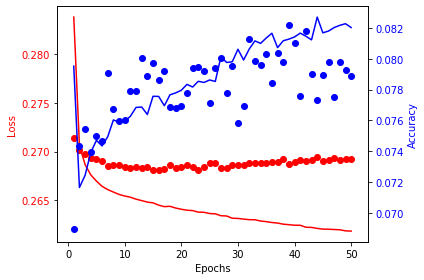

In [51]:
printHistory(history.history)

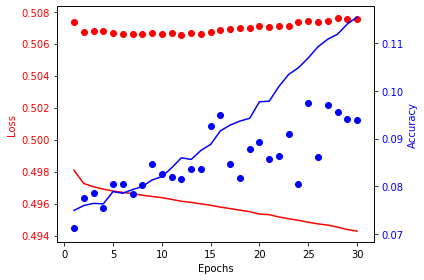

In [17]:
printHistory(history.history)

In [52]:
model_skills_conv1d.save('./models/model_skills_conv1d2.h5')

In [84]:
model_eval = createEvaluationModel_1(n_abilities*2)
model_eval.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_32 (Dense)             (None, 50)                1550      
_________________________________________________________________
dense_33 (Dense)             (None, 70)                3570      
_________________________________________________________________
dense_34 (Dense)             (None, 40)                2840      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 41        
Total params: 9,531
Trainable params: 9,531
Non-trainable params: 0
_________________________________________________________________


In [7]:
dfwinloose = pd.read_excel('./data/dataset 3 (10 people，25 competences, label)2.xlsx', index_col=0, usecols="B:BA")
dfwinloose.head()

,1,2,3,4,5,6,7,8,9,10,...,42,43,44,45,46,47,48,49,50,51
0,,,,,,,,,,,,,,,,,,,,,
1857075079,2,1,1,3,2,1,1,0,0,0,...,1,2,0,2,2,0,0,1,1,0
1886474639,2,1,3,0,0,1,2,1,0,2,...,2,0,0,1,1,0,0,1,0,0
1919021946,2,2,1,2,1,2,2,0,0,0,...,0,1,0,1,1,0,2,1,0,0
1944067475,1,2,2,1,2,2,3,0,0,1,...,1,0,1,0,1,0,0,2,0,1
1950365896,4,2,2,1,0,3,4,1,0,1,...,0,1,1,1,1,0,0,2,0,0


In [8]:
left = dfwinloose.iloc[:, :n_abilities]
righ = dfwinloose.iloc[:, n_abilities:n_abilities*2]
label = dfwinloose.iloc[:, n_abilities*2:n_abilities*2+1 ]
X = np.concatenate((left.values, righ.values), 1)
Y = label.values

In [93]:
X.shape

(130988, 50)

In [86]:
model_eval.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 4)
history = model_eval.fit(X, Y, epochs = 30, validation_split = 0.3) #, batch_size = 128, callbacks = [early_stopping])

Train on 91691 samples, validate on 39297 samples
Epoch 1/30
91691/91691 [==============================] - 13s 142us/step - loss: 0.6892 - acc: 0.5394 - val_loss: 0.6906 - val_acc: 0.5331
Epoch 2/30
91691/91691 [==============================] - 13s 141us/step - loss: 0.6888 - acc: 0.5403 - val_loss: 0.6914 - val_acc: 0.5330
Epoch 3/30
91691/91691 [==============================] - 15s 163us/step - loss: 0.6887 - acc: 0.5400 - val_loss: 0.6908 - val_acc: 0.5331
Epoch 4/30
91691/91691 [==============================] - 15s 166us/step - loss: 0.6887 - acc: 0.5403 - val_loss: 0.6912 - val_acc: 0.5337
Epoch 5/30
91691/91691 [==============================] - 14s 157us/step - loss: 0.6886 - acc: 0.5405 - val_loss: 0.6910 - val_acc: 0.5328
Epoch 6/30
91691/91691 [==============================] - 13s 137us/step - loss: 0.6884 - acc: 0.5404 - val_loss: 0.6905 - val_acc: 0.5341
Epoch 7/30
91691/91691 [==============================] - 13s 139us/step - loss: 0.6882 - acc: 0.5426 - val_loss: 0.

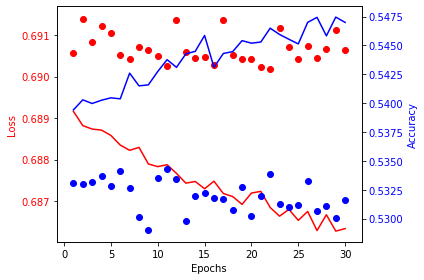

In [87]:
printHistory(history.history)

In [88]:
model_eval.save('./models/model_eval.h5')

In [ ]:
printHistory(history.history) # conv1d [32 64] [64 32] 

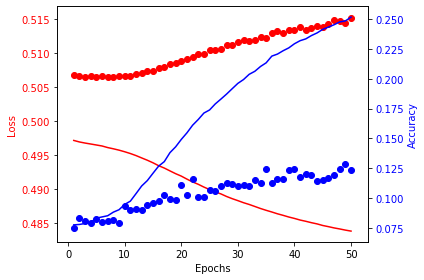

In [45]:
printHistory(history.history) # conv1d [64 128 256 Leaky] [256, 128, 64] 

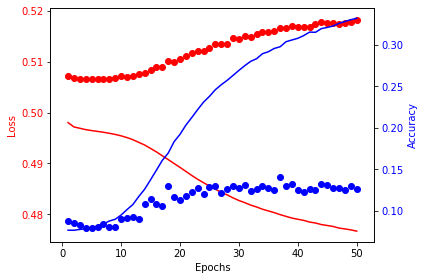

In [41]:
printHistory(history.history) # conv1d [64 128 256] [256, 128, 64]

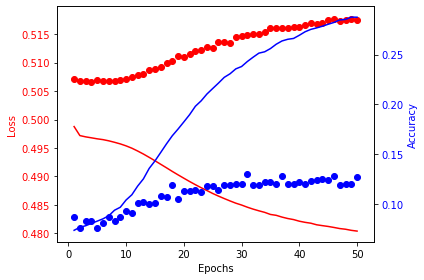

In [38]:
printHistory(history.history) # conv1d [64 128] [256, 128, 64]

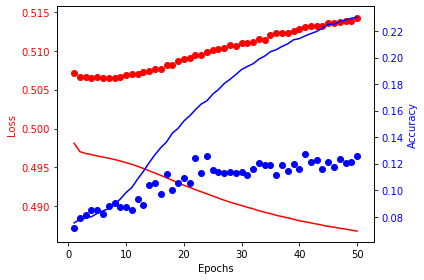

In [25]:
printHistory(history.history)

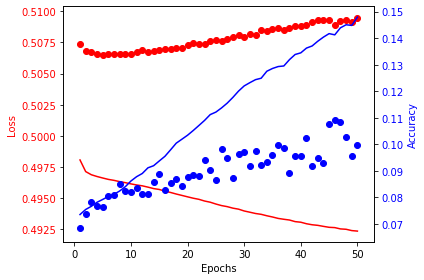

In [171]:
printHistory(history.history) # Conv2d loss='mse', optimizer=optimizers.RMSprop() [32 64] [64 32] input type (1, 2, n)

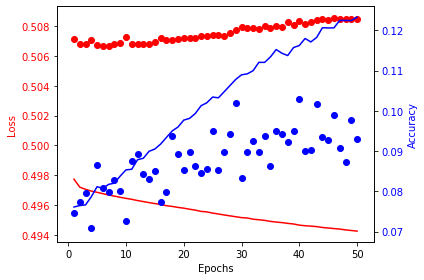

In [157]:
printHistory(history.history) # Conv2d loss='mse', optimizer=optimizers.RMSprop() [32 64] [64 32] input type (2, n, 1)

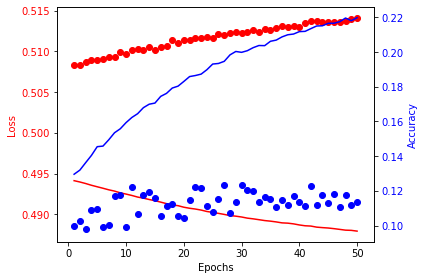

In [155]:
printHistory(history.history) # Dense loss='mse', optimizer=optimizers.RMSprop() [256 128 64]

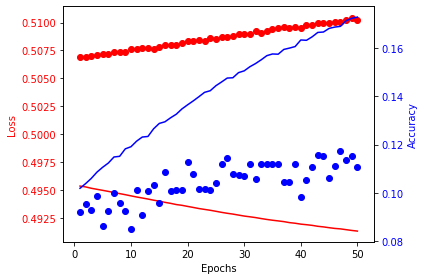

In [152]:
printHistory(history.history) # Conv1d loss='mse', optimizer=optimizers.Adam(0.0002, 0.5), [64 64],[128,64,32]

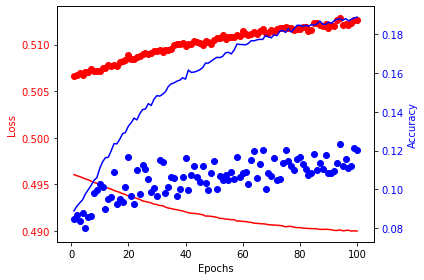

In [137]:
printHistory(history.history) # Conv1d loss='mse', optimizer=optimizers.RMSprop(), [64 64],[128,64,32]

# IGNORE NEXT CHARTS (could be used as failure examples though) 

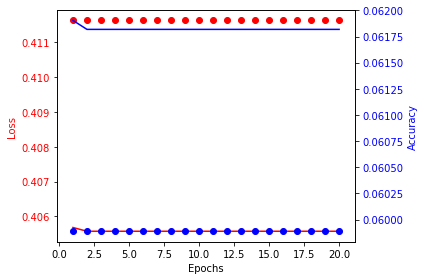

In [118]:
printHistory(history.history) # Conv 

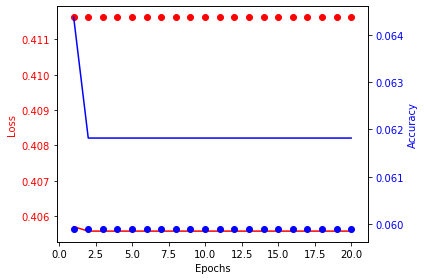

In [35]:
printHistory(history.history) # mae, adam, [64, 128, 64] (corrected activation first)

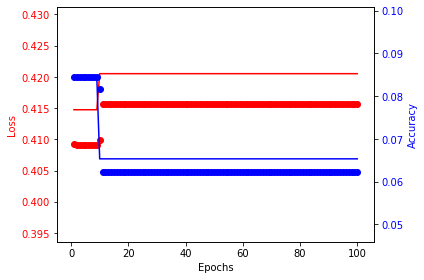

In [53]:
printHistory(history.history) # mae, adam, [128, 128, 64]

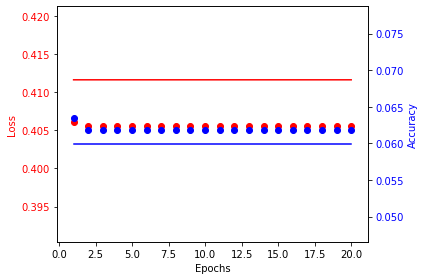

In [45]:
printHistory(history.history) # mae, adam, [64, 64, 32]

Text(0.5, 1.0, 'Learning rate')

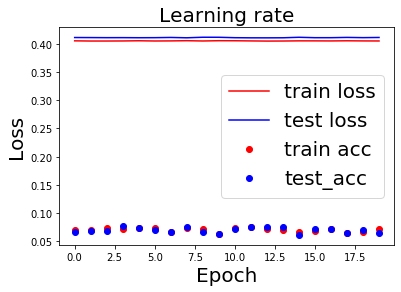

In [38]:
# mae adam 128 64 32
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.plot(history.history['acc'], 'ro')
plt.plot(history.history['val_acc'], 'bo')
plt.ylabel('Loss', size=20)
plt.xlabel('Epoch', size=20)
plt.legend(['train loss', 'test loss', 'train acc', 'test acc'])
plt.title('Learning rate', size=20)

Text(0.5, 1.0, 'Learning rate')

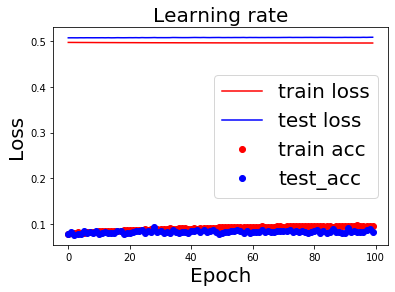

In [34]:
# mse adam 128 64 32
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.plot(history.history['acc'], 'ro')
plt.plot(history.history['val_acc'], 'bo')
plt.ylabel('Loss', size=20)
plt.xlabel('Epoch', size=20)
plt.legend(['train loss', 'test loss', 'train acc', 'test_acc'])
plt.title('Learning rate', size=20)

In [28]:
model_winner = LOLModel({
    # input info
    'input_shape': (20,),
    # Layers info
    'units_first': 64,        'activation_first': 'relu',
    'units_hidden': [32, 16], 'activations_hidden': ['relu', 'relu'],
    'units_last': 1,         'activation_last': 'softmax',
}).create()
model_winner.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 64)                1344      
_________________________________________________________________
dense_21 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_22 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


In [5]:
#model_skills = models.load_model('./models/model_skills_conv1d.h5')
model_skills = models.load_model('./models/model_skills_conv1d2.h5')
model_eval = models.load_model('./models/model_eval.h5')

W1217 17:46:38.248809 140474648766272 deprecation_wrapper.py:119] From /home/valeporti/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1217 17:46:38.297717 140474648766272 deprecation_wrapper.py:119] From /home/valeporti/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1217 17:46:38.345044 140474648766272 deprecation_wrapper.py:119] From /home/valeporti/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1217 17:46:38.345810 140474648766272 deprecation_wrapper.py:119] From /home/valeporti/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placehol

In [6]:
model_skills.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 2, 64)             1664      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 2, 64)             4160      
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
__________

In [7]:
skillsdf = pd.read_excel('./data/lol_dataset_24.xlsx', index_col=0, 
                         usecols="B:B, D:H, J:O, Q:U, W:AA, AC:AE, AG",
                         skiprows=[1, 129, 130, 131]
                        )
skillsdf = skillsdf.replace(np.nan, 0)
skillsdf.head()

,difficulty (fault/fallibility),defender,attacker (type 1),attacker (type 2),control skill (large-scale),control skill (monocase),displacement,telesportation,telesportation with others,support in long distance,...,shield,hook,trap陷阱,rush,dammage in large scale,视野view,地形change landforme,召唤师 summoner,单秒 kill in one seconde,bleed
championName,,,,,,,,,,,,,,,,,,,,,
Annie,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
Olaf,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Galio,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Twisted Fate,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Xin Zhao,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
class LOLProduct: 
    def __init__(self, model_skills, model_eval, player_skills, n_abilities = 25):
        self.model_skills = model_skills # Model
        self.model_eval = model_eval # Model
        self.player_skills = player_skills # Dataframe Chamipon -> skills
        self.n_abilities = n_abilities
        
    def getChampionAbilities(self, champion = ''):
        return self.player_skills.loc[champion]
    
    def aggregateAbilities(self, abilities = []):
        agg = abilities[0]
        for i in range(1, len(abilities)): agg = agg + abilities[i]
        return agg
    
    def getAllChampionsAbilities(self, champions = []):
        abilities = [ self.getChampionAbilities(ch) for ch in champions ]
        return self.aggregateAbilities(abilities)
    
    def extractRecommendations(self, titles, rec):
        rec = normalize(rec, norm='max') * 2
        rec = np.around( rec, 0 )
        return { titles[i]: rec[0][i]  for i in range(len(rec[0])) if rec[0][i] > 0 }, rec[0]
            
    def recommend(self, players_team = [], players_adv = [], model_ty = 'conv1D', display = True, is_abilities = False):
        if len(players_team) != len(players_adv) and len(players_adv) != 3: raise ValueError("missing players")
        if model_ty != 'conv1D' and model_ty != 'conv2D' and model_ty != 'dense': raise ValueError('Wrong model type')
        # get habilties
        team = self.getAllChampionsAbilities(players_team) if not is_abilities else players_team
        adv = self.getAllChampionsAbilities(players_adv) if not is_abilities else players_adv
        
        X = np.concatenate((team.values, adv.values))
        x_train = None
        if model_ty == 'conv1D': x_train = np.reshape(X, (1, 2, self.n_abilities))
        elif model_ty == 'conv2D': x_train = np.reshape(X, (1, 1, 2, self.n_abilities))
        else: x_train = X
        # introduce to the model
        y_skills = self.model_skills.predict(x_train)
        to_print_rec, y_skills = self.extractRecommendations( team.index.values, y_skills )
        # Show recommandations
        if display: 
            print('the recommendations are: ')
            pp.pprint( to_print_rec )
        # add recommandation
        team_total_abilities = self.aggregateAbilities([ y_skills, team ])

        return y_skills, team_total_abilities
    
    def getRandomChampions(self, n=2):
        rand_index = np.random.randint(0, len(self.player_skills)+1, size=n)
        return self.player_skills.iloc[ rand_index - 1 ]
    
    def createAdversaryAbilitiesCombo(self, players_adv = [], real_adv_ab = []):
        new_champs = None; new_abi = None; adv = None
        if len(real_adv_ab) == 0:
            n = 5 - len(players_adv)
            adv = self.getAllChampionsAbilities(players_adv)
            new_champs = self.getRandomChampions(n)
            new_abi = self.aggregateAbilities(new_champs.values)
        else :
            adv = players_adv
            new_abi = real_adv_ab
        return self.aggregateAbilities([ adv, new_abi ])
    
    def compete(self, players_team = [], players_adv = [], model_ty = 'conv1D', display = True, real_adv_ab = [],
                is_abilities = False, recommend=True):
        # get teams' abilities
        y_skills = None; team_total_abilities = None; adv_total_abilities = None;
        if recommend: 
            y_skills, team_total_abilities = self.recommend(players_team, players_adv, model_ty, display=display, is_abilities=is_abilities)
            adv_total_abilities = self.createAdversaryAbilitiesCombo(players_adv, real_adv_ab)
        else:
            team = self.getAllChampionsAbilities(players_team)
            new_champs = self.getRandomChampions(2)
            y_skills = self.aggregateAbilities(new_champs.values)
            team_total_abilities = self.aggregateAbilities([ team, y_skills ])
            adv_total_abilities = players_adv
        
        X = np.concatenate((team_total_abilities.values, adv_total_abilities.values))
        X = np.reshape(X, (1, 50))

        y_compete = self.model_eval.predict(X)
        win_loose = round(y_compete[0][0])
        
        if display:
            print('Won!!') if win_loose == 0 else print('Looooost!')
        return win_loose, y_compete[0][0], y_skills, adv_total_abilities
    
    def simulateRandom(self, simulations = 100, compare=False, champions = 3, result_display=True, display=False):
        scores = []; recommantations = [0] * self.n_abilities; comparisons = []
        for i in range(simulations):
            team = self.getRandomChampions(champions)
            adve = self.getRandomChampions(champions)
            win_loose, wl_by, y_skills, adv_ab = self.compete(team.index.values, adve.index.values, display=display)
            scores.append(win_loose)
            recommantations = recommantations + y_skills
            if compare: 
                win_loose2, wl_by2, y_skills2, _ = self.compete(team.index.values, adv_ab, 
                                                      display=display, recommend=False)
                #print(wl_by, wl_by2, (wl_by > wl_by2), win_loose )
                comparisons.append( (wl_by > wl_by2) )
            
        mark = 1 - sum(scores) / len(scores)
        comp_mark = 1 - sum(comparisons) / len(comparisons) if compare else 0
        if result_display: print(f' { round(10000 * mark) / 100 } % of simulations were won')
        if result_display and compare: print(f' { round(10000 * comp_mark) / 100 } % of simulations were won by comparing')
        return scores, mark, recommantations, comparisons
    
    def simulateReal(self, df_first_3, dfwinloose, real_adv=True,  
                     simulations=100, result_display=True, display=False):
        scores = []
        for i in range(simulations):
            win33, los33, los22, win, los = self.getRealChampions( df_first_3, dfwinloose )
            if real_adv:
                print(los22, win33)
                win_loose, _, y_skills = self.compete(win33, los33, display=display, real_adv_ab=los22, is_abilities=True)
            else:
                win_loose, _, y_skills = self.compete(win33, los33, display=display, is_abilities=True)
            scores.append(win_loose)
        return scores
    
    def getRealChampions(self, df_first_3, dfwinloose):
        rand_index = np.random.randint(0, len(dfwinloose.index.values)+1, size=1)
        row = dfwinloose.iloc[rand_index[0], :]
        label = row[len(row)] #indexed with number 1-51
        len_teams = int(len(row) - 1)
        win = row[ 0 : int(len_teams/2) ] if label == 0 else row[ int(len_teams/2) : len_teams ]
        los = row[ 0 : int(len_teams/2) ] if label == 1 else row[ int(len_teams/2) : len_teams ]
        rand_team = row.name
        row33 = df_first_3.loc[rand_team]
        win33 = row33[ 0 : int(len_teams/2) ]
        los33 = row33[ int(len_teams/2) : len_teams ]
        los22 = los.subtract(los33)
        print(los33, los22)
        return win33, los33, los22, win, los
        

In [20]:
prod = LOLProduct(model_skills, model_eval, skillsdf)
score, mark, rec, comp = prod.simulateRandom(simulations=10000, compare=True)

 92.41 % of simulations were won
 55.28 % of simulations were won by comparing


In [57]:
v = pd.DataFrame(rec)

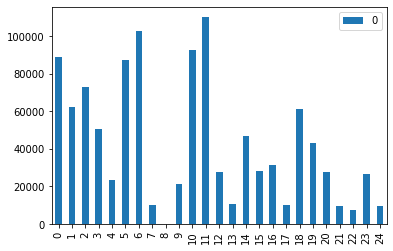

In [58]:
v.plot(kind='bar')

In [ ]:
prod = LOLProduct(model_skills, model_eval, skillsdf)
score = prod.simulateReal(df33, dfwinloose, simulations=10000)

In [87]:
team_champs = ['Bard', 'Fiora', 'Galio']
adv_champs = ['Nautilus', "Vel'Koz", 'Syndra']
prod = LOLProduct(model_skills, model_eval, skillsdf)
v = prod.recommend(team_champs, adv_champs)

the recommendations are: 
{'attack in Long distance': 9.0,
 'attacker (type 1)': 9.0,
 'attacker (type 2)': 5.0,
 'bleed': 1.0,
 'control skill  (monocase)': 8.0,
 'control skill (large-scale)': 2.0,
 'cure others': 1.0,
 'dammage in large scale': 4.0,
 'defender': 6.0,
 'difficulty (fault/fallibility)': 9.0,
 'displacement': 11.0,
 'hook': 3.0,
 'rush': 7.0,
 'self cure': 3.0,
 'self shield': 4.0,
 'shield': 2.0,
 'start fight': 11.0,
 'support in long distance': 2.0,
 'telesportation': 1.0,
 'trap陷阱': 1.0,
 '单秒 kill in one seconde': 3.0,
 '召唤师 summoner': 1.0,
 '地形change landforme': 1.0,
 '视野view': 3.0}


In [123]:
left = dfwinloose.iloc[:, :n_abilities]
righ = dfwinloose.iloc[:, n_abilities:n_abilities*2]
label = dfwinloose.iloc[:, n_abilities*2:n_abilities*2+1 ]
X = np.concatenate((left.values, righ.values), 1)
Y = label.values

0.1203

In [12]:
a = np.array([3, 5, 6]).reshape(1,-1)
normalize(a, norm='max')

array([[0.5       , 0.83333333, 1.        ]])

In [72]:
prod.getRandomChampions(3)

,difficulty (fault/fallibility),defender,attacker (type 1),attacker (type 2),control skill (large-scale),control skill (monocase),displacement,telesportation,telesportation with others,support in long distance,...,shield,hook,trap陷阱,rush,dammage in large scale,视野view,地形change landforme,召唤师 summoner,单秒 kill in one seconde,bleed
championName,,,,,,,,,,,,,,,,,,,,,
Jayce,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Azir,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Alistar,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [182]:
tot_index = len(dfwinloose.index.values)
rand_index = np.random.randint(0, len(dfwinloose.index.values)+1, size=1)
print(rand_index)
row = dfwinloose.iloc[rand_index[0], :]
label = int(row[len(row)]) #indexed with number 1-51
len_teams = int(len(row) - 1)
win = row[ 0 : int(len_teams/2) ] if label == 0 else row[ int(len_teams/2) : len_teams ]
los = row[ 0 : int(len_teams/2) ] if label == 1 else row[ int(len_teams/2) : len_teams ]
row33 = df33.loc[ row.name ]
win33 = row33[ 0 : int(len_teams/2) ]
los33 = row33[ int(len_teams/2) : len_teams ]
los22 = los.values - los33.values
print(row.name, row33.name)
print(row.values)
print(row33.values)
print(los.values)
print(los33.values)
print(los22)



[40664]
2289454189 2289454189
[2 2 2 0 0 3 1 0 0 0 1 2 0 0 1 0 1 0 2 0 0 0 0 0 0 2 3 2 0 1 3 3 0 0 0 1 4
 0 0 1 0 2 0 2 0 0 0 0 2 0 1]
[1 1 1 0 0 2 1 0 0 0 0 1 0 0 1 0 0 0 2 0 0 0 0 0 0 1 1 2 0 1 1 2 0 0 0 1 2
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 2
 0]
[2 2 2 0 0 3 1 0 0 0 1 2 0 0 1 0 1 0 2 0 0 0 0 0 0]
[1 1 2 0 1 1 2 0 0 0 1 2 0 0 0 0 0 0 1 0 0 0 0 0 0]
[ 1  1  0  0 -1  2 -1  0  0  0  0  0  0  0  1  0  1  0  1  0  0  0  0  0
  0]


In [143]:
len(los33)

25

In [68]:
los33

26    2
27    2
28    1
29    1
30    0
31    2
32    2
33    1
34    0
35    1
36    3
37    2
38    1
39    0
40    1
41    1
42    2
43    0
44    1
45    2
46    1
47    1
48    0
49    0
50    0
Name: 2348298435, dtype: int64

In [69]:
los

26    2
27    2
28    1
29    1
30    0
31    2
32    2
33    1
34    0
35    1
36    3
37    2
38    1
39    0
40    1
41    1
42    2
43    0
44    1
45    2
46    1
47    1
48    0
49    0
50    0
Name: 2348298435, dtype: int64

In [49]:
skillsdf

,difficulty (fault/fallibility),defender,attacker (type 1),attacker (type 2),control skill (large-scale),control skill (monocase),displacement,telesportation,telesportation with others,support in long distance,...,shield,hook,trap陷阱,rush,dammage in large scale,视野view,地形change landforme,召唤师 summoner,单秒 kill in one seconde,bleed
championName,,,,,,,,,,,,,,,,,,,,,
Annie,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
Olaf,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Galio,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Twisted Fate,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Xin Zhao,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Azir,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Thresh,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Rek'Sai,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
v = np.around(v, 0)

In [54]:
team_ab.values

array([0., 2., 1., 1., 2., 2., 1., 1., 0., 1., 1., 2., 0., 0., 1., 0., 1.,
       0., 1., 1., 0., 0., 1., 1., 0.])

In [37]:
abilities = team_ab.index.values
{ abilities[i]: v[0][i]  for i in range(len(v[0])) if v[0][i] > 0 }


{'difficulty (fault/fallibility)': 2.0,
 'control skill  (monocase)': 3.0,
 'displacement': 1.0,
 'start fight': 4.0}

In [91]:
prod = LOLProduct(model_skills, model_eval, skillsdf)

In [102]:
adv_ab.values

array([1., 1., 1., 2., 1., 3., 1., 1., 0., 1., 2., 3., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 1., 1., 0.])

In [111]:
X = np.concatenate((team_ab.values, adv_ab.values))

array([0., 2., 1., 1., 2., 2., 1., 1., 0., 1., 1., 2., 0., 0., 1., 0., 1.,
       0., 1., 1., 0., 0., 1., 1., 0.])

In [105]:
team_ab

array([0., 2., 1., 1., 2., 2., 1., 1., 0., 1., 1., 2., 0., 0., 1., 0., 1.,
       0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 2., 1., 3., 1., 1., 0.,
       1., 2., 3., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0.])

In [113]:
x_train_c1d = np.reshape(X, (2, n_abilities))

In [114]:
x_train_c1d

array([[0., 2., 1., 1., 2., 2., 1., 1., 0., 1., 1., 2., 0., 0., 1., 0.,
        1., 0., 1., 1., 0., 0., 1., 1., 0.],
       [1., 1., 1., 2., 1., 3., 1., 1., 0., 1., 2., 3., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 1., 1., 0.]])